## GAN starter code
Corresponding tutorial: [https://youtu.be/_pIMdDWK5sc](https://youtu.be/_pIMdDWK5sc)

In [ ]:
!pip install pytorch-lightning

In [ ]:
pip uninstall pytorch-lightning

Found existing installation: pytorch-lightning 2.5.0.post0
Uninstalling pytorch-lightning-2.5.0.post0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/lightning_fabric/*
    /usr/local/lib/python3.11/dist-packages/pytorch_lightning-2.5.0.post0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/pytorch_lightning/*
Proceed (Y/n)? Y
  Successfully uninstalled pytorch-lightning-2.5.0.post0


In [ ]:
pip install pip==23.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
pip install pytorch-lightning==1.5.10

In [ ]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [ ]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [ ]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [ ]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [ ]:
# TODO: GAN

class GAN(pl.LightningModule):
  def __init__(self, latent_dim=100, lr=0.0002):
    super().__init__()
    self.save_hyperparameters()

    self.generator = Generator(latent_dim=self.hparams.latent_dim)
    self.discriminator = Discriminator()

    # Random noise
    self.validation_z = torch.randn(6, self.hparams.latent_dim)

  def forward(self, z):
    return self.generator(z)

  def adversarial_loss(self, y_hat, y):
    return F.binary_cross_entropy(y_hat, y)

  def training_step(self, batch, batch_idx, optimizer_idx):
    real_imgs, _ = batch

    # Sampel noise
    z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
    z = z.type_as(real_imgs)

    # train generator: max log(D(G(z)))   # z is random noise
    if optimizer_idx == 0:
      fake_imgs = self(z)   # execute forward pass
      y_hat = self.discrminator(fake_imgs)

      y = torch.ones(real_imgs.size(0), 1)
      y = y.type_as(real_imgs)

      g_loss = self.adversarial_loss(y_hat, y)

      log_dict = {"g_loss": g_loss}
      return {"loss": g_loss, "progress_bar": log_dict, "log": log_dict}

    # train discriminator: max log(D(x)) + log(1 - D(G(z)))
    if optimizer_idx == 1:

      # how well can it label as real
      y_hat_real = self.discriminator(real_imgs)

      y_real = torch.ones(real_imgs.size(0), 1)
      y_real = y_real.type_as(real_imgs)

      real_loss = self.adversarial_loss(y_hat_real, y_real)

      # how well can it label as fake
      y_hat_fake = self.discriminator(self(z).detach()) # detach from computational graph

      y_fake = torch.ones(real_imgs.size(0), 1)
      y_fake = y_fake.type_as(real_imgs)

      fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

      d_loss = (real_loss + fake_loss) / 2

      log_dict = {"d_loss": d_loss}
      return {"loss": d_loss, "progress_bar": log_dict, "log": log_dict}

  def configure_optimizers(self):
    lr = self.hparams.lr
    opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr) # optimizer for generator
    opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr) # optimizer for discriminator
    return [opt_g ,opt_d], []

  def plot_imgs(self):
    z = self.validation_z.type_as(self.generator.lin1.weight)
    sample_imgs = self(z).cpu()

    print('epoch', self.current_epoch)
    fig = plt.figure()
    for i in range(sample_imgs.size(0)):
      plt.subplot(2, 3, i+1)
      plt.tight_layout()
      plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap='gray_r', interpolation='none')
      plt.title("generated data")
      plt.xticks([])
      plt.yticks([])
      plt.axis('off')
    plt.show()

  def on_epoch_end(self):
    self.plot_imgs()



In [ ]:
dm = MNISTDataModule()
model = GAN()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/lightning.py:2054: DeprecationWarning: `torch.distributed._sharded_tensor` will be deprecated, use `torch.distributed._shard.sharded_tensor` instead
  from torch.distributed._sharded_tensor import pre_load_state_dict_hook, state_dict_hook


In [ ]:
model.plot_imgs()

In [ ]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, dm)

Epoch [10/10]: 100%|██████████| 600/600 [00:29<00:00, 20.57batch/s, d_loss=0.178, g_loss=5.05]


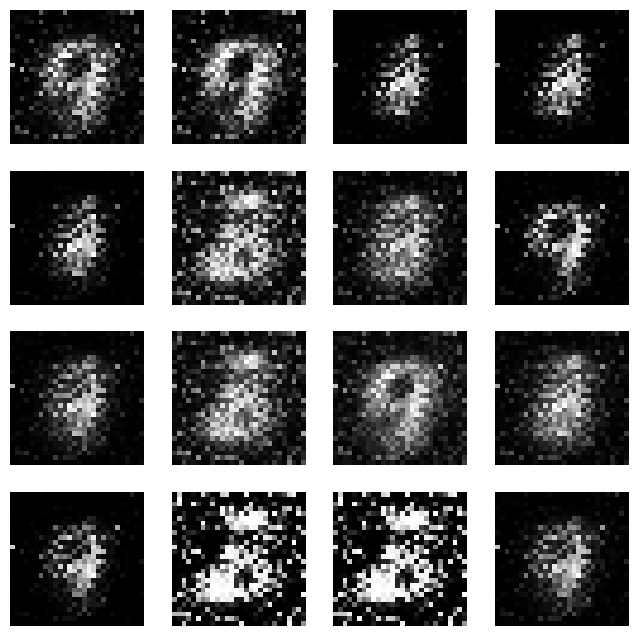

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm

# Hyperparameters
latent_size = 64
hidden_size = 256
num_epochs = 10
batch_size = 100
learning_rate = 0.0002

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

mnist = dsets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, 28 * 28),
            nn.Tanh()  # Output should be in range [-1, 1]
        )

    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()  # Output should be in range [0, 1]
        )

    def forward(self, x):
        return self.model(x.view(-1, 28 * 28))

# Instantiate models
generator = Generator()
discriminator = Discriminator()

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    with tqdm(total=len(data_loader), desc=f'Epoch [{epoch+1}/{num_epochs}]', unit='batch') as pbar:
        for i, (images, _) in enumerate(data_loader):
            # Create labels for real and fake images
            real_labels = torch.ones(images.size(0), 1)
            fake_labels = torch.zeros(images.size(0), 1)

            # Train Discriminator
            optimizer_d.zero_grad()
            outputs = discriminator(images)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(images.size(0), latent_size)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()

            # Update progress bar
            pbar.set_postfix(d_loss=d_loss_real.item() + d_loss_fake.item(), g_loss=g_loss.item())
            pbar.update(1)  # Increment the progress bar

    # Generate images for visualization every 10 epochs
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            fake_images = generator(torch.randn(16, latent_size))
            fake_images = fake_images.view(-1, 1, 28, 28)
            fake_images = fake_images * 0.5 + 0.5  # Rescale to [0, 1]

            # Plot generated images
            plt.figure(figsize=(8, 8))
            for j in range(fake_images.size(0)):
                plt.subplot(4, 4, j+1)
                plt.imshow(fake_images[j][0], cmap='gray')
                plt.axis('off')
            plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, img_shape),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_shape, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.model(img)

# Hyperparameters
latent_dim = 100
img_shape = 28 * 28
lr = 0.0002
batch_size = 64
epochs = 20

# Initialize models, optimizers, and loss function
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss()

# Load dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # Adversarial ground truths
        real = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(imgs.view(imgs.size(0), -1)), real)
        z = torch.randn(imgs.size(0), latent_dim)
        fake_loss = criterion(discriminator(generator(z).detach()), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim)
        g_loss = criterion(discriminator(generator(z)), real)
        g_loss.backward()
        optimizer_G.step()

        # Print losses
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

[Epoch 0/20] [Batch 0/938] [D loss: 1.3643673658370972] [G loss: 0.6565861701965332]
[Epoch 0/20] [Batch 100/938] [D loss: 0.2972860038280487] [G loss: 4.722469329833984]
[Epoch 0/20] [Batch 200/938] [D loss: 0.34581539034843445] [G loss: 5.259608745574951]
[Epoch 0/20] [Batch 300/938] [D loss: 0.03169477358460426] [G loss: 5.612252712249756]
[Epoch 0/20] [Batch 400/938] [D loss: 0.028328534215688705] [G loss: 7.122250080108643]
[Epoch 0/20] [Batch 500/938] [D loss: 0.028917744755744934] [G loss: 6.544302463531494]
[Epoch 0/20] [Batch 600/938] [D loss: 0.03698084503412247] [G loss: 5.4957804679870605]
[Epoch 0/20] [Batch 700/938] [D loss: 0.05550587177276611] [G loss: 5.907449722290039]
[Epoch 0/20] [Batch 800/938] [D loss: 0.2441263496875763] [G loss: 5.721304416656494]
[Epoch 0/20] [Batch 900/938] [D loss: 0.04272760823369026] [G loss: 6.558753490447998]
[Epoch 1/20] [Batch 0/938] [D loss: 0.10163070261478424] [G loss: 7.661258220672607]
[Epoch 1/20] [Batch 100/938] [D loss: 0.097283

## SimCLR

## LLMs

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "gpt2"  # Replace with your preferred model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

def ask_agent(question):
    prompt = f"Q: {question}\nA:"
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=125)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

# Ask the agent a question
response = ask_agent("What is the capital of France?")
print(response)  # Output: "The capital of France is Paris."

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Q: What is the capital of France?
A: The capital of France is Paris.
Q: What is the capital of France?
A: The capital of France is Paris.
Q: What is the capital of France?
A: The capital of France is Paris.
Q: What is the capital of France?
A: The capital of France is Paris.
Q: What is the capital of France?
A: The capital of France is Paris.
Q: What is the capital of France?
A: The capital of France is Paris.
Q: What is the


In [3]:
import math

def calculator(expression):
    try:
        return str(eval(expression))
    except:
        return "Invalid expression."

def ask_agent_with_tools(question):
    if "calculate" in question.lower():
        expression = question.replace("calculate", "").strip()
        return calculator(expression)
    else:
        return ask_agent(question)

# Ask the agent to calculate
response = ask_agent_with_tools("Calculate 2 + 2 * 3.")
print(response)  # Output: "8"

Invalid expression.


In [5]:
memory = []

def ask_agent_with_memory(question):
    memory.append(f"User: {question}")
    context = "\n".join(memory[-3:])  # Use the last 3 interactions as context
    prompt = f"{context}\nAgent:"
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=100)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    memory.append(f"Agent: {answer}")
    return answer

# Interact with the agent
response = ask_agent_with_memory("What is 2 + 2?")
print(response)  # Output: "2 + 2 is 4."
response = ask_agent_with_memory("What is the square root of that?")
print(response)  # Output: "The square root of 4 is 2."

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


KeyboardInterrupt: 